In [30]:
# We have a workflow that we will be using:
what_we_are_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [31]:
# Import the libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check your PyTorch version
torch.__version__

'2.2.1+cu121'

In [32]:
# We are going to learn to estimate a straight line
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now that we've gotten our data we will build a model.

this model will learn the relationship between X (features) and y (labels).

We will separate our data into training (80%) and test (20%) data.

In [33]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [34]:
# Let's create a function to visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    '''
    Plots training data, test data and compares predictions.
    '''
    plt.figure(figsize=(10, 7))

    # Plot the training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions data")

    # Show the legend
    plt.legend(prop={"size": 14})

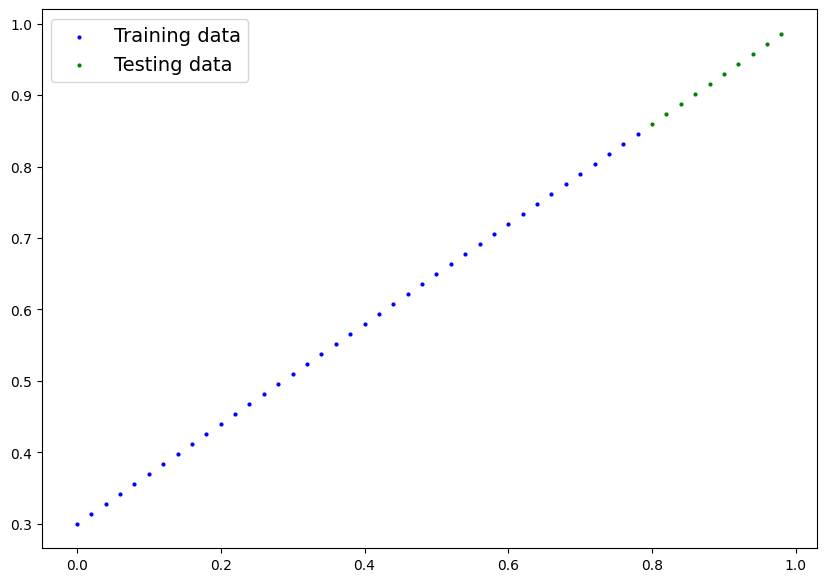

In [35]:
plot_predictions()

In [36]:
# We will make a linear regression model clss
class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [37]:
# Let's initialize a model and check the parameters
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [38]:
# We can get the state of the model using .state_dict()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [39]:
# Let's make some predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

In [40]:
# Let's check how well the predictions compare
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")
print(f"Actual values:\n{y_test}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
Actual values:
tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


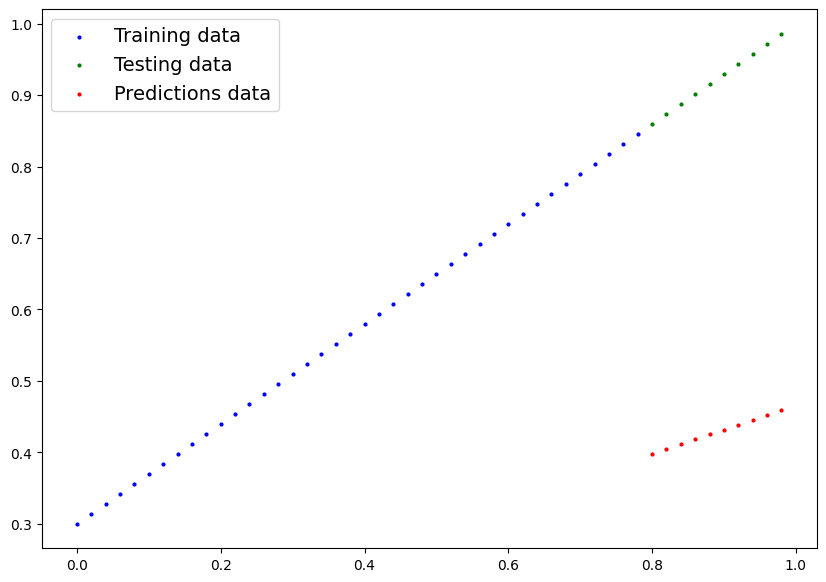

In [41]:
plot_predictions(predictions=y_preds)

In [42]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

In [43]:
# Let's train our model
# Create a loss function
loss_fn = nn.L1Loss() # Mean Absolute Error

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [44]:
# Let's make the training and testing loop:
torch.manual_seed(42)

# Set the number of epoch (how many times the model will pass through the loop)
EPOCHS = 100

# Create lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(EPOCHS):
    # Start with the training - put it in training mode
    model_0.train()

    # Forward pass on train data
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # Set the gradients of the optimizer to zero
    optimizer.zero_grad()

    # Calculate the loss backwards
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    # Now test the model - put it in testing mode
    model_0.eval()

    with torch.inference_mode():
        # Do a forward pass
        test_pred = model_0(X_test)

        # Calculate the loss on test data
        test_loss = loss_fn(test_pred, y_test)

        # Print every 10 epochs what is happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


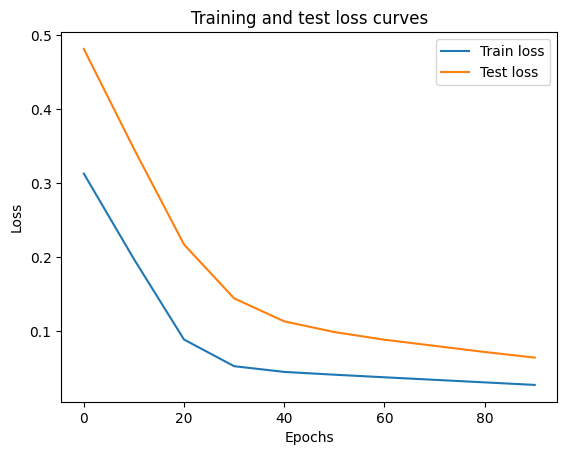

In [45]:
# Let's plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()